# Image classification model

We will start with creating an image classification model which we will later use to build an object detection model. At this stage we will use tensorflow.

Useful links:
https://www.tensorflow.org/tutorials/images/classification,
https://www.youtube.com/watch?v=qFJeN9V1ZsI&ab_channel=freeCodeCamp.org

In [1]:
# Imports
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import PIL

# Layers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
os.getcwd()

'/Users/sofyamalashchenko/Documents/Sofya/Uni stuff/Waterloo Winter 2022/Ingredient-detection'

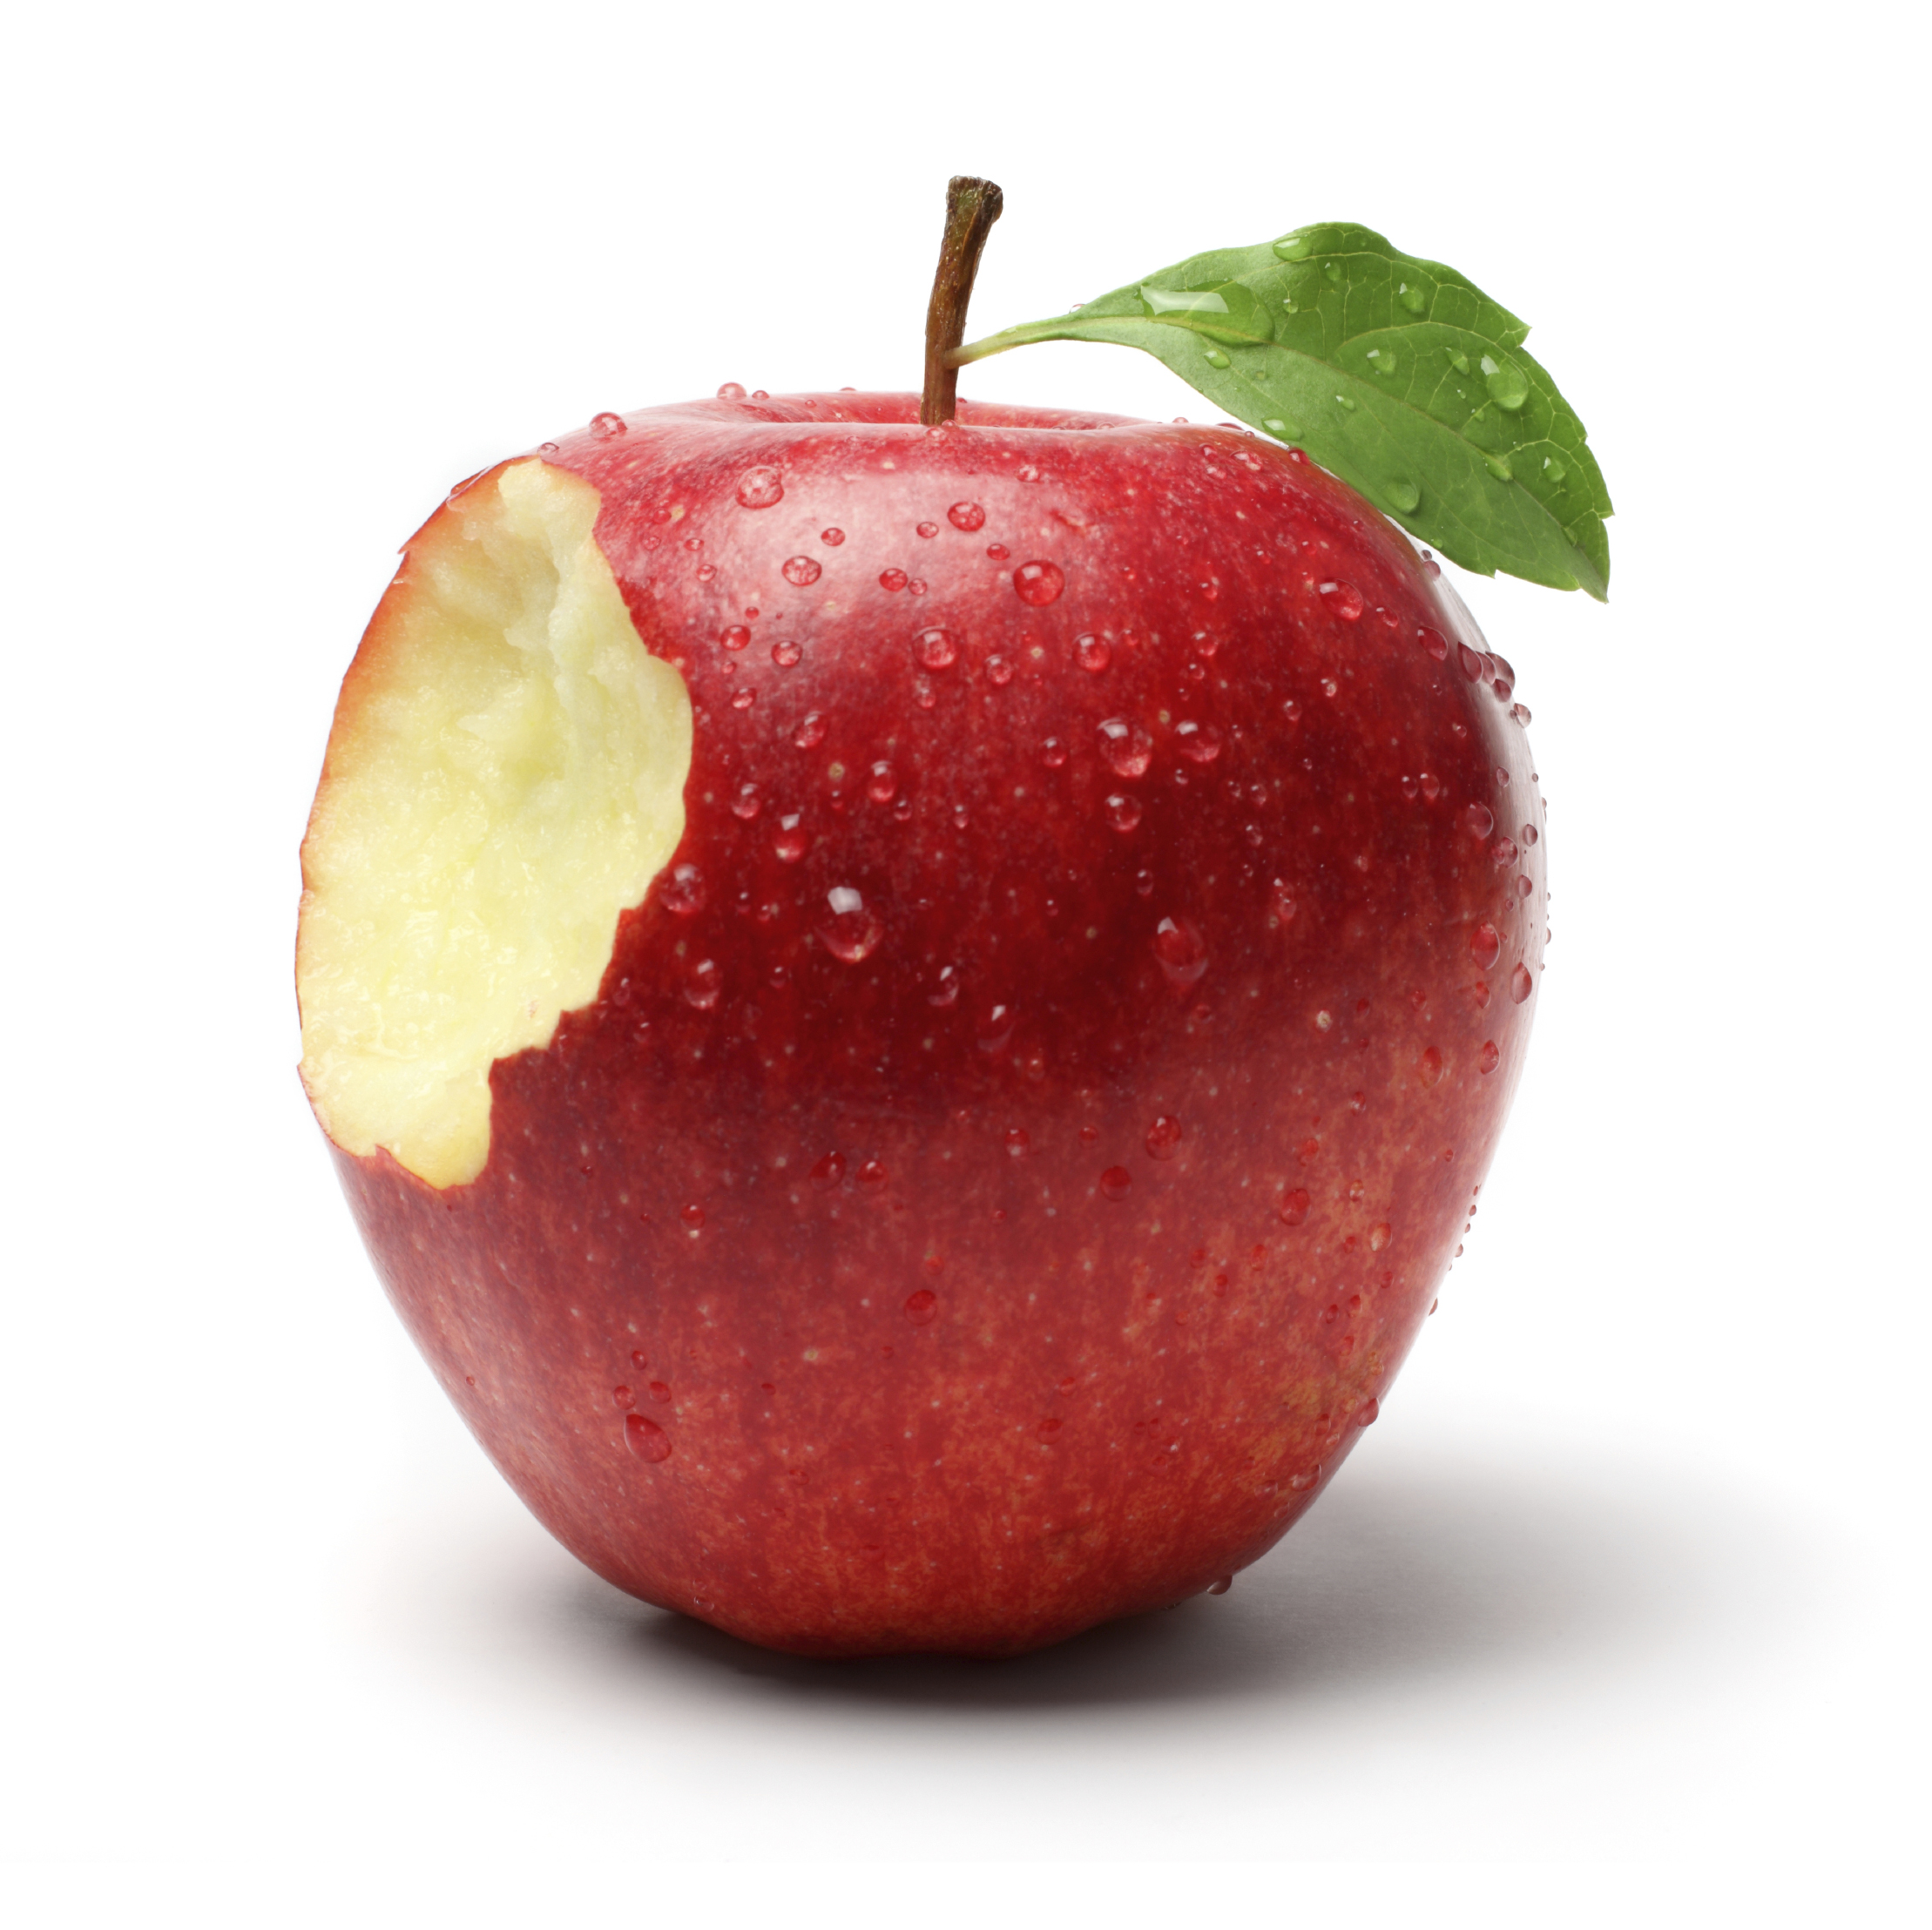

In [3]:
data_path = "/Users/sofyamalashchenko/Documents/Sofya/Uni stuff/Waterloo Winter 2022/Ingredient-detection/Initial_ingredients"
item = "apple"
n = 1
PIL.Image.open("{path}/{item}/Image_{n}.jpg".format(path = data_path, item = item, n = n))

In [4]:
# Batch_size defines the number of samples that will be propagated through the network.
# https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
batch_size = 32
# The size to which the images will be resized when loaded
img_height = 256
img_width = 256

Now, we will use these parameters to load the data

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels = "inferred",
    validation_split = 0.2, # 20% of the data will be used for validation
    subset="training",
    seed = 1,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 65 files belonging to 6 classes.
Using 52 files for training.


2022-03-31 22:56:07.041905: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


And validation data

In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="validation",
  seed=1,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 65 files belonging to 6 classes.
Using 13 files for validation.


In [10]:
type(val_ds)

TypeError: 'BatchDataset' object is not subscriptable